## Deep Learning Framework based on theano
- [github](https://github.com/fchollet/keras)
- [website](http://keras.io/)
- [examples showing off modelling capability](http://keras.io/examples/)
- [example codes on image/text data](https://github.com/fchollet/keras/tree/master/examples)

### Philosophy
- fast prototyping with flexible and minimal configuration: Torch like interface within Python, also supports sklearn-like prediction interface, e.g., `fit`, `train_on_batch`, `evaluate`, `predict_classes`, `predict_proba`.
- run on both cpu and gpu
- support both convotlutional networks and recurrent networks
- easy to extend

### Basic Usage
Like almost all other apis, the main compoents of keras are (1) different types of layers (2) model (net) consisting of layers and a loss function, (3) optimizers and (4) optionally some data-processing facilities e.g. for image/text/sequence data. 

### Main APIS

#### A. [Data Processing](http://keras.io/preprocessing/sequence/) - most of them are helper functions, and helper processors
- packages: 
    - `keras.preprocessing.sequence` for sequence data
    - `keras.preprocessing.text` for text data
    - `keras.preprocessing.image` for image data
- image data: for image data, the input format should be (nimages, nchannels, width, height)

#### B. [Layers](http://keras.io/layers/core/)
- packages:
    - `keras.layers.core` for core layers
    - `keras.layers.convolutional` for convolution/pooling layers
    - `keras.layers.recurrent` for recurrent layers
    - `keras.layers.advanced_activations` as its name suggests
    - `keras.layers.normalization` for normalizations
    - `keras.layers.embeddings` for text embedding (vector representation)
    - `keras.layers.noise` for noise-adding
    - `keras.layers.containers` for ensemble/composite layers, e.g. sequentially stacked multilayers
- activation functions: activations of layers can be specified (1) either via a separate activation layer or (2) through the activation argument supported by all forward layers.Existing activations are
    - softmax: expect shape to be either (nsamples, ntimesteps, ndims) or (nsamples, ndims)
    - softplus
    - relu
    - tanh
    - sigmoid
    - hard_sigmoid
    - linear
- initialization of layer weights can be specified by `init` param in the layer construtor, out-of-box initialization include
    - uniform
    - lecun_uniform (uniform initialization scaled by sqrt of nins)
    - normal
    - identity 
    - orthogonal
    - zero
    - glorot_normal (Gaussian initialization scaled by nin+nout)
    - glorot_uniform
    - he_normal
    - he_uniform
- regularization of layer weights: they are either on layer weights and/or layer activations. These are done via three parameters to a layer. The parameters can have different regularizer instances from the `keras.regularizers` package.
    - `W_regularizer`: l1(l=0.01), l2(l=0.01), l1l2(l1=0.01, l2=0.01)
    - `b_regularizer`: l1(l=0.01), l2(l=0.01), l1l2(l1=0.01, l2=0.01)
    - `activity_regularizer`: activity_l1(l=0.01), activity_l2(l=0.01), activity_l1l2(l1=0.01, l2=0.01)
- constraints: some layers need constraints, see [doc](http://keras.io/constraints/) for details

#### C. [Objective Functions](http://keras.io/objectives/)
Objective functions can be specifed either by name (see below the out-of-box objective function names) or a Theano symbolic function that returns a scalar for each data point - exmaples can be found in [source code](https://github.com/fchollet/keras/blob/master/keras/objectives.py). Available functions include,
- mean_squared_error / mse
- mean_absolute_error / mae
- mean_absolute_percentage_error / mape
- mean_squared_logarithmic_error / msle
- squared_hinge: only for binary classification
- hinge: only for binary classification
- binary_crossentropy: Also known as logloss.
- categorical_crossentropy: aka softmax for multi-classification. ***It needs the labels are in one-hot-encoding, i.e., binary arrays of shape (nsamples, nclasses)***

Note that keras follows the convention of theano where the final output function (e.g., softmax) is treated as an activation, instead of part of loss function (as in Caffe)

#### D. [Optimizers](http://keras.io/optimizers/) 
Existing optimizers and their parameters can be found in the [doc](http://keras.io/optimizers/).
- [comparison of different optimization e.g. rmsprop](http://www.erogol.com/comparison-sgd-vs-momentum-vs-rmsprop-vs-momentumrmsprop/)

#### E. [Callback functors](http://keras.io/callbacks/)
Callback functors are subclasses of `keras.callbacks.Callback` with specific event slots such as `on_train_begin/end(logs={})`, `on_epoch_begin/end(epoch, logs={})`, `on_batch_begin/end(batch, logs={})`. The commonly used out-of-box callbacks are 
- `ModelCheckpoint(filepath, verbose = 0, save_best_only=False)`: Save the model after every epoch. If save_best_only=True, the latest best model according to the validation loss will not be overwritten.
- `EarlyStopping(monitor='val_loss', patience=0, verbose=0)`: Stop training after no improvement of the metric monitor is seen for patience epochs. The parameter of monitor is a key in the `logs` dictionary passed into event listeners.

#### F. [Models](http://keras.io/models/)
- it is the main access point for training/evaluating. 
- it assembles other components such as layers, objective functions and optimizers, e.g.,
    - add layer by `model.add`
    - set loss function and optimizer in `model.compile`
    - set callback functions in `model.fit`
- specify callback functions at different stages
- typical steps to build a keras model
    - [optionally] massage the data into right format via data process helpers
    - create a model via constructors (most of time Sequential, sometime Graph)
    - create layers and add them to the model by `model.add`
    - specify loss function and optimizer by `model.compile`
    - [optionally] specify callback functions for house-keeping
    - train the model with data by `model.fit` or `model.batch_train`
    - evaluate the performance and go back to tune the parameters and models
    - make predictions on new data

## read and visualize the inner layer of model
keras exposes the layers and its parameters, activations via the `.layers` member. See below an example (IMDB with 1Dcnn - text classification with 1dcnn to utilize context information) of reading intermediate layer (word embedding) for details. The trick is from the [discussion](https://github.com/fchollet/keras/issues/431#issuecomment-124175958).

And that is pretty much everything to know about keras for a good start. It is highly recommended to read its well written [source code](https://github.com/fchollet/keras).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Typical Model Structures in keras

## Examples 

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.utils import np_utils ## utility functions

Using gpu device 0: Quadro K2000


### MNIST with vanila MLP

In [3]:
## load minist raw images 
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print train_X.shape, test_X.shape, train_y.shape, test_y.shape

## massage the data to normalize/vectorize
## vectorizing images this way wont assume any spatial information in iamges, contrary to cnn
def process_mnist_input(images):
    return images.reshape((-1, 28 * 28)).astype(np.float32) / 255.
## one-hot encoding of class labels, required by softmax-crossentropy loss
def process_mnist_output(labels):
    return np_utils.to_categorical(labels, nb_classes=10)
train_X, test_X = process_mnist_input(train_X), process_mnist_input(test_X)
print train_X.shape, test_X.shape
train_y, test_y = process_mnist_output(train_y), process_mnist_output(test_y)
print train_y.shape, test_y.shape

## build the model - vanila mlp
model = Sequential()
model.add(Dense(28 * 28, 128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, 128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, 10, activation="softmax"))
rms = RMSprop()
model.compile(loss = "categorical_crossentropy", optimizer = rms)

## train model under an sklearn interface
## model snapshot callback
save_model = ModelCheckpoint("../data/tmp/keras_mnist_nlp.h5")
model.fit(train_X, train_y, batch_size=128, nb_epoch=20, 
          show_accuracy=True, verbose=2, validation_split=0.3, callbacks=[save_model])

## evaluate on test data
print model.evaluate(test_X, test_y, show_accuracy=True, verbose=0)
np.mean(model.predict_classes(test_X) == test_y.argmax(axis = 1))

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 784) (10000, 784)
(60000, 10) (10000, 10)
Train on 42000 samples, validate on 18000 samples
Epoch 0
1s - loss: 0.4978 - acc: 0.8542 - val_loss: 0.2258 - val_acc: 0.9312
Epoch 1
1s - loss: 0.2276 - acc: 0.9333 - val_loss: 0.1624 - val_acc: 0.9503
Epoch 2
1s - loss: 0.1712 - acc: 0.9490 - val_loss: 0.1409 - val_acc: 0.9586
Epoch 3
1s - loss: 0.1368 - acc: 0.9589 - val_loss: 0.1167 - val_acc: 0.9653
Epoch 4
1s - loss: 0.1180 - acc: 0.9646 - val_loss: 0.1055 - val_acc: 0.9688
Epoch 5
1s - loss: 0.1024 - acc: 0.9685 - val_loss: 0.1080 - val_acc: 0.9689
Epoch 6
1s - loss: 0.0920 - acc: 0.9719 - val_loss: 0.0979 - val_acc: 0.9708
Epoch 7
1s - loss: 0.0849 - acc: 0.9741 - val_loss: 0.0989 - val_acc: 0.9723
Epoch 8
1s - loss: 0.0760 - acc: 0.9760 - val_loss: 0.0970 - val_acc: 0.9719
Epoch 9
1s - loss: 0.0706 - acc: 0.9775 - val_loss: 0.0972 - val_acc: 0.9728
Epoch 10
1s - loss: 0.0645 - acc: 0.9795 - val_loss: 0.0884 - val_acc: 0.9746
Ep

0.97870000000000001

### MNIST with cnn - utilizing the spatial correlation

In [4]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

## load data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## massage data for cnn - make gray data into 3D Tensor, normalize, and convert to float32 for gpu
## sometime you need to resize, or crop images to the right shape
## one-hot-encode labels
def process_mnist_input(images):
    return images[:, np.newaxis, :, :].astype(np.float32) / 255.
def process_mnist_output(labels):
    return np_utils.to_categorical(labels)
## train_X and test_X shape should be compatible with Caffe input (nexamples x nchannels x width x height)
train_X = process_mnist_input(train_X)
test_X = process_mnist_input(test_X)
print train_X.shape, test_X.shape
train_y, test_y = process_mnist_output(train_y), process_mnist_output(test_y)
print train_y.shape, test_y.shape

## build cnn - the convolution2D layer doesn't need you to specify stride, because it follows best practice
model = Sequential()
model.add(Convolution2D(nb_filter = 32, stack_size = 1, nb_row = 3, nb_col = 3, 
                        border_mode="full", activation="relu"))
model.add(Convolution2D(nb_filter = 32, stack_size = 32, nb_row = 3, nb_col = 3, 
                        activation="relu"))
model.add(MaxPooling2D(poolsize=(2, 2)))
model.add(Dropout(.25))

model.add(Flatten()) ## flatten to vectors - from convolution layer to vector layer
## 28x28 image after (2, 2)-pooling becomes (14, 14)
model.add(Dense(32 * 14 * 14, 128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(128, 10, activation="softmax"))

## compile with loss function and optimizer
## benchmark the time to compile
%time model.compile(loss = "categorical_crossentropy", optimizer = "adadelta")

## train the model
model.fit(train_X, train_y, batch_size=512, nb_epoch=10, 
          validation_split=0.3, show_accuracy=True, verbose=2)
print model.evaluate(test_X, test_y, show_accuracy=True)

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)
CPU times: user 5.64 s, sys: 96.3 ms, total: 5.74 s
Wall time: 5.97 s
Train on 42000 samples, validate on 18000 samples
Epoch 0
38s - loss: 0.6492 - acc: 0.7977 - val_loss: 0.1884 - val_acc: 0.9431
Epoch 1
39s - loss: 0.1796 - acc: 0.9476 - val_loss: 0.1440 - val_acc: 0.9555
Epoch 2
38s - loss: 0.1263 - acc: 0.9626 - val_loss: 0.1589 - val_acc: 0.9509
Epoch 3
38s - loss: 0.0997 - acc: 0.9703 - val_loss: 0.1270 - val_acc: 0.9617
Epoch 4
38s - loss: 0.0864 - acc: 0.9744 - val_loss: 0.0751 - val_acc: 0.9763
Epoch 5
38s - loss: 0.0745 - acc: 0.9772 - val_loss: 0.0702 - val_acc: 0.9784
Epoch 6
39s - loss: 0.0699 - acc: 0.9786 - val_loss: 0.0594 - val_acc: 0.9815
Epoch 7
38s - loss: 0.0632 - acc: 0.9806 - val_loss: 0.0443 - val_acc: 0.9868
Epoch 8
38s - loss: 0.0584 - acc: 0.9826 - val_loss: 0.0453 - val_acc: 0.9869
Epoch 9
38s - loss: 0.0514 - acc: 0.9844 - val_loss: 0.0579 - val_acc: 0.9834
10000/10000 [=========================

1/1 [==============================] - 0s


array([9])

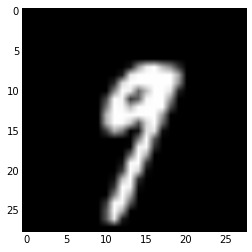

In [5]:
## test how to apply the model onto new images ... maybe different shape?
## the shape matters
i = np.random.randint(0, test_X.shape[0])
newimg = test_X[i, ...]
plt.imshow(newimg[0, :, :], cmap = plt.cm.gray)
model.predict_classes(np.array([newimg]))

(1, 28, 28)
(1, 56, 56)


ValueError: dimension mismatch in args to gemm (1,25088)x(6272,128)->(1,128)
Apply node that caused the error: GpuDot22(GpuReshape{2}.0, <CudaNdarrayType(float32, matrix)>)
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(1, 25088), (6272, 128)]
Inputs strides: [(0, 1), (128, 1)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

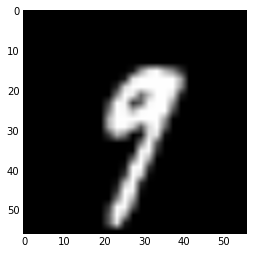

In [7]:
from scipy import ndimage as nd
from scipy import spatial
from scipy import misc
print newimg.shape
resizedimg = misc.imresize(newimg[0, ...], 2.)[np.newaxis, ...]
plt.imshow(resizedimg[0, ...], cmap = plt.cm.gray)
print resizedimg.shape

## shapes matter
model.predict_classes(np.array([resizedimg]))

### CIFAR10 cnn

(50000, 3, 32, 32) (10000, 3, 32, 32) (50000, 1) (10000, 1)
(50000, 100) (10000, 100)
CPU times: user 7.08 s, sys: 151 ms, total: 7.23 s
Wall time: 7.34 s
Train on 35000 samples, validate on 15000 samples
Epoch 0
35000/35000 [==============================] - 71s - loss: 4.5466 - acc: 0.0188 - val_loss: 4.4486 - val_acc: 0.0339
Epoch 1
35000/35000 [==============================] - 71s - loss: 4.2136 - acc: 0.0587 - val_loss: 3.9629 - val_acc: 0.1035
Epoch 2
35000/35000 [==============================] - 71s - loss: 3.9165 - acc: 0.0968 - val_loss: 3.7315 - val_acc: 0.1446
Epoch 3
35000/35000 [==============================] - 71s - loss: 3.7326 - acc: 0.1308 - val_loss: 3.5765 - val_acc: 0.1699
Epoch 4
35000/35000 [==============================] - 71s - loss: 3.5743 - acc: 0.1566 - val_loss: 3.4776 - val_acc: 0.1848
Epoch 5
35000/35000 [==============================] - 71s - loss: 3.4323 - acc: 0.1795 - val_loss: 3.2822 - val_acc: 0.2099
Epoch 6
35000/35000 [========================

KeyboardInterrupt: 

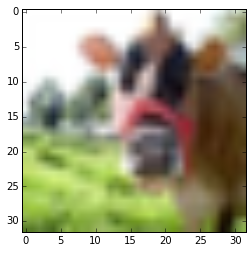

In [8]:
## data preparation and image/label mungling
from keras.datasets import cifar100
from keras.preprocessing import image
from keras.utils import np_utils
## cnn network layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
## optimizers
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint

## load data
(train_X, train_y), (test_X, test_y) = cifar100.load_data()
print train_X.shape, test_X.shape, train_y.shape, test_y.shape
plt.imshow(train_X[0, ...].transpose((1, 2, 0)))
## massage images - it is already in the shape as its nimages x nchannles x height x width
def process_cifar_input(images):
    return images.astype(np.float32) / 255.
## one-hot encoding of ylabel
def process_cifar_output(labels):
    return np_utils.to_categorical(labels)
train_X, test_X = process_cifar_input(train_X), process_cifar_input(test_X)
train_y, test_y = process_cifar_output(train_y), process_cifar_output(test_y)
print train_y.shape, test_y.shape

## construct the network
model = Sequential()
model.add(Convolution2D(32, 3, 3, 3, border_mode="full", activation="relu"))
model.add(Convolution2D(32, 32, 3, 3, activation="relu"))
model.add(MaxPooling2D(poolsize=(2, 2))) # the dimension is now 32 * 16 * 16
model.add(Dropout(.25))

## always use a full border, instead of default vaild mode, otherwise the potential mismatch with next layer  
model.add(Convolution2D(64, 32, 3, 3, activation="relu", border_mode="full"))
model.add(Convolution2D(64, 64, 3, 3, activation="relu"))
model.add(MaxPooling2D(poolsize=(2, 2))) # the dimension is now 64 * 8 * 8
model.add(Dropout(.25))

model.add(Flatten())
model.add(Dense(64*8*8, 512, activation="relu"))
model.add(Dropout(.5))
model.add(Dense(512, 100, activation="softmax"))

## learner
sgd = SGD(lr=0.05, decay=1e-6, momentum=.9, nesterov=True)
%time model.compile(optimizer = sgd, loss = "categorical_crossentropy")

## set callback and train
monitor = EarlyStopping(monitor="val_loss", patience=600)
backup = ModelCheckpoint(filepath = "../data/tmp/cifar_cnn.hd5", save_best_only=True)

model.fit(train_X, train_y, batch_size=512, nb_epoch=100, 
          show_accuracy=True, validation_split=.3, callbacks=[monitor, backup])
print model.evaluate(test_X, test_y, show_accuracy=True)

In [9]:
## runnable even after stop in the middle
print model.evaluate(test_X, test_y, show_accuracy=True)

10000/10000 [==============================] - 5s     
[2.6258319358825686, 0.41760000000000003]


1/1 [==============================] - 0s
[66]


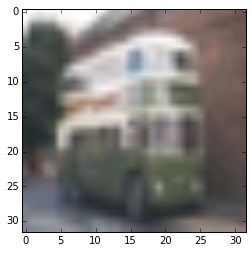

In [11]:
i = np.random.randint(0, test_X.shape[0])
print model.predict_classes(test_X[i:i+1, ...])
plt.imshow(test_X[i, ...].transpose((1, 2, 0)))

### IMDB with 1Dcnn - text classification with 1dcnn to utilize context information

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution1D, MaxPooling1D

Using gpu device 0: Quadro K2000


In [2]:
## train_X and test_X are different articles/reviews
## words in articles are already hashed based on their frequences, e.g. 3 encodes 3rd most frequent word, 
## "0" encode unknown word, specially for padding
## train_y and test_y are sentiment labels (negative/positive)
max_features = 5000 ## hash size for the maxium number of words (the top max_features words in the articles)
(train_X, train_y), (test_X, test_y) = imdb.load_data(nb_words=max_features, test_split=.2)
print len(train_X), "train sequences"
print len(test_X), "test sequences"

## pad the sequence data to the same length
maxlen = 120
def process_input(texts):
    return sequence.pad_sequences(texts, maxlen=maxlen)
def process_output(labels):
    ## binary classification
    return labels
train_X, test_X = process_input(train_X), process_input(test_X)
print train_X.shape, test_X.shape

## build the model 1d-cnn
model = Sequential()
## embed the word hash index into vectors in embedded space
## input_dim: size of vocabulary
embedding_dim = 100
model.add(Embedding(input_dim = max_features, output_dim = embedding_dim))
model.add(Dropout(0.25))
## input shape: (nb_samples, steps, input_dim)
## output_shape: (nb_samples, steps, nb_filter)
## subsample_length: factor by which to subsample output in sequence
nb_filter = 250
filter_length = 3
model.add(Convolution1D(input_dim = embedding_dim, 
                        nb_filter = nb_filter, 
                        filter_length = filter_length, 
                        border_mode = "valid", 
                        activation = "relu", 
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2, ))

model.add(Flatten())
## tricky part: set the output dim of convolution network
hidden_dims = 250
output_size = nb_filter * ( (maxlen - filter_length)/1 +1) / 2
print output_size
## an easy to calculate way is to set outputsize to random value, and theano will throw exception on that
## with the right number
model.add(Dense(output_size, hidden_dims, activation="relu"))
model.add(Dropout(.25))

model.add(Dense(hidden_dims, 1, activation="sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", class_mode = "binary")
model.fit(train_X, train_y, batch_size=32, nb_epoch=3, show_accuracy=True, validation_split=0.3)
print model.evaluate(test_X, test_y, show_accuracy=True)

20000 train sequences
5000 test sequences
(20000, 120) (5000, 120)
14750
Train on 14000 samples, validate on 6000 samples
Epoch 0
14000/14000 [==============================] - 30s - loss: 0.6814 - acc: 0.5429 - val_loss: 0.5827 - val_acc: 0.6927
Epoch 1
14000/14000 [==============================] - 30s - loss: 0.4372 - acc: 0.7933 - val_loss: 0.3859 - val_acc: 0.8232
Epoch 2
5000/5000 [==============================] - 2s     
[0.35544735221862794, 0.83620000000000005]


In [3]:
model.layers

In [4]:
## get the output from an intermediate layer - the embedding layer
from theano import function
embedding_layer = model.layers[0]
embedding_fn = function(inputs = [model.get_input(train=False)], outputs=embedding_layer.get_output(train=False))
article_vectors = embedding_fn(test_X[:5, :])
print article_vectors.shape

maxpool_layer = model.layers[3]
maxpool_fn = function(inputs = [model.get_input(train=False)], outputs=maxpool_layer.get_output(train=False))
print maxpool_fn(test_X[:5, :]).shape

(5, 120, 100)
(5, 59, 250)


In [5]:
## verify the same word has the same embedded vector representation
import numpy as np
articles, words = np.where(test_X[:5, :] == 11)
article_vectors[articles, words, :]

array([[-0.00443324,  0.01482167,  0.04836088, ..., -0.05706451,
        -0.01478089, -0.03795658],
       [-0.00443324,  0.01482167,  0.04836088, ..., -0.05706451,
        -0.01478089, -0.03795658],
       [-0.00443324,  0.01482167,  0.04836088, ..., -0.05706451,
        -0.01478089, -0.03795658],
       ..., 
       [-0.00443324,  0.01482167,  0.04836088, ..., -0.05706451,
        -0.01478089, -0.03795658],
       [-0.00443324,  0.01482167,  0.04836088, ..., -0.05706451,
        -0.01478089, -0.03795658],
       [-0.00443324,  0.01482167,  0.04836088, ..., -0.05706451,
        -0.01478089, -0.03795658]], dtype=float32)

### IMDB sentiment analysis - lstm

In [25]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dropout

max_nb_words = 20000 ## use the most common 20000 words
max_len = 100 ## pad/truncate each review into 100 words
embedding_dim = 128 # embed the word into a 128 dim vector representation

## load data
(train_X, train_y), (test_X, test_y) = imdb.load_data(nb_words=max_nb_words, test_split=.2)
print "max lenght of review is:", max([len(r) for r in train_X+test_X])
## process data - padding
def process_input(texts):
    return sequence.pad_sequences(texts, maxlen= max_len)
train_X, test_X = process_input(train_X), process_input(test_X)
print train_X.shape, test_X.shape

## model building
## most recurrent layers assumes input to be (nsamples, nsteps, ndim)
## and they usually work with an embedding layer to get the right format
model = Sequential()
model.add(Embedding(input_dim = max_nb_words, output_dim = embedding_dim))
## LSTM process a sequence of vectors and accumulate them into one vector
model.add(LSTM(input_dim = embedding_dim, output_dim=128))
model.add(Dropout(.5))
model.add(Dense(input_dim = 128, output_dim=1, activation="sigmoid"))

## class_mode to "binary" is compulsory
model.compile(loss = "binary_crossentropy", optimizer = "adam", class_mode = "binary")

model.fit(train_X, train_y, batch_size=32, nb_epoch=4, validation_split=.3, show_accuracy=True)
print model.evaluate(test_X, test_y, show_accuracy=True)

max lenght of review is: 2821
(20000, 100) (5000, 100)
Train on 14000 samples, validate on 6000 samples
Epoch 0
14000/14000 [==============================] - 88s - loss: 0.6282 - acc: 0.6409 - val_loss: 0.4879 - val_acc: 0.7687
Epoch 1
14000/14000 [==============================] - 88s - loss: 0.3810 - acc: 0.8371 - val_loss: 0.4117 - val_acc: 0.8165
Epoch 2
14000/14000 [==============================] - 87s - loss: 0.2263 - acc: 0.9151 - val_loss: 0.4120 - val_acc: 0.8245
Epoch 3
5000/5000 [==============================] - 3s     
[0.5590675219774246, 0.81699999999999995]
